In [1]:
import os
import re
import yaml
import glob
import pathlib

import numpy as np
import pandas as pd

from math import ceil
from itertools import product

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import zarr
import napari
import tifffile
import dask.array as da

from utils.utility_functions import (single_channel_pyramid, jaccard_index)

In [2]:
# Paths and inputs
sample = 'CRC-097'

df_2d = pd.read_parquet(os.path.join(os.getcwd(), 'input/CRC-97_raw_cylinter_clustering_2d.parquet'))
df_2d = df_2d[df_2d['cluster_2d'] != -1]

df_3d = pd.read_parquet(os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_hdbscan.parquet'))
df_3d = df_3d[df_3d['cluster'] != -1]

with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast = yaml.safe_load(f)

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['channelExclusionsClustering']

# markers, dna1, dna_moniker, abx_channels = read_markers(
#     os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'), markers_to_exclude, df_2d
# )

# The parquet file at the path below is being read because "main.csv" 
# uses trimmed marker channel names as column headers that differ from the raw channel names used 
# in the markers.csv file, which is itself used to index channels in the OME-TIFF image.

for_channels = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# isolate antibodies of interest
abx_channels = [
    i for i in for_channels.columns if 'nucleiRingMask' in i if
    'Hoechst' not in i if i not in markers_to_exclude
]

# get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

out = os.path.join(os.getcwd(), 'output/2d_umap')
if not os.path.exists(out):
    os.makedirs(out)

In [3]:
# Group cell indices per cluster
dict_2d = {}
for name, group in df_2d.groupby('cluster_2d'):
    dict_2d[name] = group['CellID'].tolist()

dict_3d = {}
for name, group in df_3d.groupby('cluster'):
    dict_3d[name] = group['CellID'].tolist()

# Initialize Jaccard Index matrix with zeros
num_clusters_2d = len(dict_2d.keys())
num_clusters_3d = len(dict_3d.keys())
ji_matrix = [[0] * num_clusters_2d for _ in range(num_clusters_3d)] # 3D clusters will comprise matrix rows 

# Calculate Jaccard Index for each pair of clusters
for i, j in product(range(num_clusters_3d), range(num_clusters_2d)):
    ji_matrix[i][j] = jaccard_index(dict_3d[i], dict_2d[j])

plot_input = pd.DataFrame(ji_matrix)

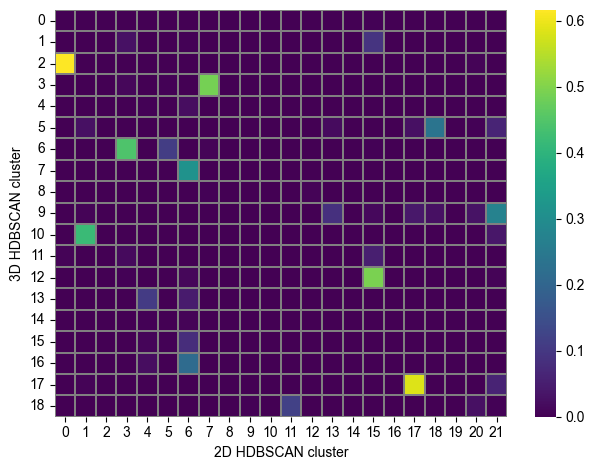

In [4]:
# Plot
plt.rcParams['font.family'] = 'Arial'
g = sns.heatmap(plot_input, cmap='viridis', linecolor='gray', linewidth=0.1)
g.set_ylabel('3D HDBSCAN cluster')
g.set_xlabel('2D HDBSCAN cluster')
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(out, f'2D-3D_Jaccard_indices.pdf'), bbox_inches='tight')
plt.show()

In [5]:
# Get 3D HDBSCAN cluster 17 Cell IDs
clus17_3d_ids = df_3d['CellID'][df_3d['cluster'] == 17]

# Assign a dummy variable (100) to 2D HDBSCAN cluster 17 cells in 3D HDBSCAN cluster 17 
ids_17 = df_2d['CellID'][(df_2d['cluster_2d'] == 17) & (df_2d['CellID'].isin(clus17_3d_ids))]
df_2d.loc[df_2d.index[df_2d['CellID'].isin(ids_17)], 'cluster_2d'] = 100  # dummy cluster label

# Assign a dummy variable (101) to 2D HDBSCAN cluster 17 cells in 3D HDBSCAN cluster 17
ids_21 = df_2d['CellID'][(df_2d['cluster_2d'] == 21) & (df_2d['CellID'].isin(clus17_3d_ids))]
df_2d.loc[df_2d.index[df_2d['CellID'].isin(ids_21)], 'cluster_2d'] = 101  # dummy cluster label

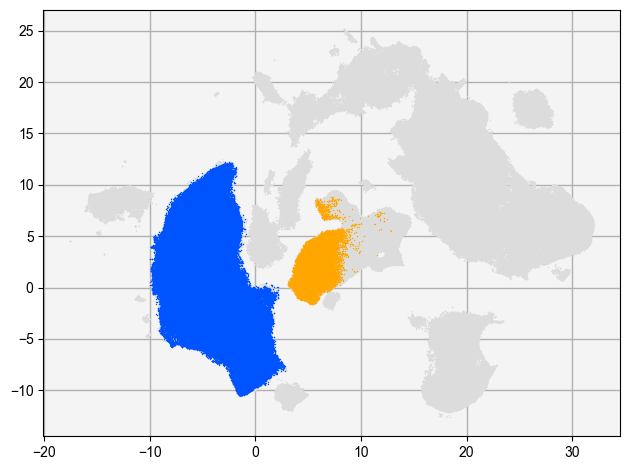

In [6]:
# Highlight clusters in 2D UMAP embedding
fig, ax = plt.subplots()

ax.scatter(df_2d['emb1'], df_2d['emb2'], s=1.0, lw=0.0, c='gainsboro')

ax.scatter(
    df_2d['emb1'][df_2d['cluster_2d'] == 100], df_2d['emb2'][df_2d['cluster_2d'] == 100],
    s=1.0, lw=0.0, color=(0, 0.33, 1)
)

ax.scatter(
    df_2d['emb1'][df_2d['cluster_2d'] == 101], df_2d['emb2'][df_2d['cluster_2d'] == 101],
    s=1.0, lw=0.0, color=(1, 0.65, 0)
)

ax.set_facecolor('#f4f4f4')

ax.grid(True, lw=1)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig(os.path.join(out, 'umap.png'), dpi=800)
plt.show()
plt.close('all')

In [7]:
# Show clusters in the CRC image
viewer = napari.Viewer()

sample_path = (
    pathlib.Path(glob.glob(os.path.join(os.getcwd(), f'input/{sample}_image*.tif'))[0]).resolve()
)
abx_channels.reverse()
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(sample_path, channel=(channel_number.item() - 1))
    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False,
        name=ch, contrast_limits=(contrast[ch][0], contrast[ch][1])
    )

seg_path = pathlib.Path(
    glob.glob(os.path.join(os.getcwd(), f'input/{sample}_seg_outlines*.tif'))[0]).resolve()
seg, min, max = single_channel_pyramid(seg_path, channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3, contrast_limits=(min, max)
)

dna, min, max = single_channel_pyramid(sample_path, channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True, opacity=0.8,
    name='DNA1', contrast_limits=(min, max)
)

centroids = df_3d[['Y_centroid', 'X_centroid']][df_3d['cluster'] == 17]
viewer.add_points(
        centroids, name='3d_clus17', face_color='#0055ff',
        edge_width=0.0, size=10.0, opacity=1.0, blending='translucent',
        visible=False
    )

centroids = df_2d[['Y_centroid', 'X_centroid']][df_2d['cluster_2d'] == 100]
viewer.add_points(
        centroids, name='2d_clus17_in_3d_clus17', face_color='#0055ff',
        edge_width=0.0, size=10.0, opacity=1.0, blending='translucent',
        visible=False
    )

centroids = df_2d[['Y_centroid', 'X_centroid']][df_2d['cluster_2d'] == 101]
viewer.add_points(
        centroids, name='2d_clus21_in_3d_clus17', face_color='orange',
        edge_width=0.0, size=12.0, opacity=1.0, blending='translucent',
        visible=False
    )

viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()